# 🎮 GameRx  | From Emotion → Relief (Hybrid Mapping)

Bringing together two pieces:  
**how players feel** and **what they play**.

This shows how games give **psychological relief**  
and powers the Mood → Medicine recommender. 

#### 📂 Files  

**Input**
- `04_steam_reviews_emotions_full.csv` → player reviews with full emotion scores  
- `02_games_metadata_genre_ready.csv` → clean game metadata with full genre lists  

**Output**
- `06_games_emotion_relief_full.csv` → full hybrid dataset (emotions + genres)  
- `06_games_emotion_relief_light.csv` → light version for app + visuals  


#### Goal  

Find what kind of **emotional relief** each game provides.

- Do horror games help **release anger or fear**?  
- Do cozy sims **bring comfort** after stress?  
- Do story adventures **validate** or **distract**?  


#### Relief Types  

| Type | Focus |
|------|--------|
| **Comfort** | Calm, trust, joy |
| **Catharsis** | Letting go of anger, fear, sadness |
| **Validation** | Feeling understood and seen |
| **Distraction** | Shifting focus, sparking curiosity |


#### Why It Matters  

This model blends **emotion data + genre patterns**  
to understand how games help players steady their mood.

It’s the emotional engine behind **GameRx: Your Digital Dose**,  
suggesting games based on how someone wants to **feel**,  
not just what they play.

### Table of Contents

1. [Import Libraries](#1-import-libraries)  
2. [Load Cleaned Data](#2-load-cleaned-data)  
3. [Quick Sanity Check](#3-quick-sanity-check)  
4. [Define Relief Mood Categories](#4-define-relief-mood-categories)  
5. [Assign Mood Labels to Emotions](#5-assign-mood-labels-to-emotions)  
6. [Create Hybrid Relief Scores](#6-create-hybrid-relief-scores)
   - 6.1 [Assign relief_tag from Primary Emotion](#61-assign-relief_tag-from-primary-emotion)
   - 6.2 [Assign relief_tag to Each Game](#62-assign-relief_tag-to-each-game)  
7. [Generate Game-Level Relief Tags](#7-generate-game-level-relief-tags)
   - 7.1 [Genre-Based Relief Mapping (Top-Down Fallback)](#71-genre-based-relief-mapping-top-down-fallback)  
8. [Export Final Merged Dataset](#8-export-final-merged-dataset)  
9. [Visualize Relief Mapping](#9-visualize-relief-mapping)
   - 9.1 [Top Genres per Relief Tag](#91-top-genres-per-relief-tag)
   - 9.2 [Emotion Intensity by Relief Type](#92-emotion-intensity-by-relief-type)  
10. [Conclusion](#10-conclusion)

---

## 1. Import Libraries

Simple setup

 **I’ll use:**
- **Pandas** → data wrangling  
- **NumPy** → quick math  
- **Matplotlib / Seaborn** → visual checks later  
- **Path** (from `pathlib`) → clean, safe file paths  

Nothing fancy here just the core tools we always use.

In [1]:
# Core tools
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
from pathlib import Path

# Display + style settings
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", font_scale=1.1)

---

## 2. Load Cleaned Data

Time to bring in our two key files 

**Files used**
- `04_steam_reviews_emotions_full.csv` → player reviews with full emotion scores  
- `02_games_metadata_genre_ready.csv` → clean game metadata with full genre lists  

They work together:
- Reviews → show **how players feel**  
- Metadata → shows **what they play**  

In [2]:
# Load Full Emotion + Metadata Datasets
from pathlib import Path
import pandas as pd

DATA_DIR = Path(r"D:/YVC/YVC Portfolio Implementation/Data Analytics Projects/GameRx Your Digital Dose/02 Data/cleaned")

# Correct files for full mapping
REVIEWS_PATH = DATA_DIR / "04_steam_reviews_emotions_full.csv"
METADATA_PATH = DATA_DIR / "02_games_metadata_genre_ready.csv"

# Load datasets
reviews_df = pd.read_csv(REVIEWS_PATH, low_memory=False)
games_df = pd.read_csv(METADATA_PATH, low_memory=False)

print(f"✔ reviews_df: {reviews_df.shape}")
print(f"✔ games_df:   {games_df.shape}")

display(reviews_df.head(2))
display(games_df.head(2))

✔ reviews_df: (32515, 37)
✔ games_df:   (105008, 22)


,AppID,Name,genre_list,primary_genre,genre_count,Name_review,Review,review_score,review_votes,review_clean,review_length,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,review_words,affect_terms,affect_coverage_pct,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w,primary_emotion,emotion_richness,normalized_intensity
0,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"Combine Metal Slug, Ikari Warriors and Steam P...",1.0,1.0,"Combine Metal Slug, Ikari Warriors and Steam P...",273,3,5,2,6,4,5,0,2,10,7,273,44,0.161172,1.098901,1.831502,0.732601,2.197802,1.465201,1.831502,0.0,0.732601,3.663004,2.564103,positive,9,0.161172
1,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,Overhead Mech Twin Stick Shooter with gorgeous...,1.0,1.0,Overhead Mech Twin Stick Shooter with gorgeous...,53,3,1,2,3,3,2,0,1,5,3,53,23,0.433962,5.660377,1.886792,3.773585,5.660377,5.660377,3.773585,0.0,1.886792,9.433962,5.660377,positive,9,0.433962


,AppID,Name,Release date,About the game,Languages,Metacritic score,User score,Positive,Negative,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,genre_list,primary_genre,genre_count
0,20200,Galactic Bowling,10/21/2008,Galactic Bowling is an exaggerated and stylize...,['English'],0,0,6,11,30,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling","['Casual', 'Indie', 'Sports']",Casual,3
1,655370,Train Bandit,10/12/2017,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",0,0,53,5,12,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...","['Action', 'Indie']",Action,2


---

## 3. Quick Sanity Check

Now that both datasets are loaded,  
time for a quick health check.

### What I’m confirming
- Emotion score columns exist in `reviews_df`  
- `AppID` matches across both datasets  
- No odd missing values in key fields  

Just making sure everything is solid  
before building the relief scores.

In [3]:
# Check if all expected emotion columns exist
emotion_columns = [
    'anger', 'anticipation', 'disgust', 'fear', 
    'joy', 'sadness', 'surprise', 'trust', 
    'positive', 'negative'
]
missing_cols = [col for col in emotion_columns if col not in reviews_df.columns]
if not missing_cols:
    print("✔ All emotion columns found.")
else:
    print("⚠ Missing emotion columns:", missing_cols)

# Check that AppID is present in both datasets
print("✔ 'AppID' in reviews_df:", 'AppID' in reviews_df.columns)
print("✔ 'AppID' in games_df:", 'AppID' in games_df.columns)

# Check for missing emotion values
if set(emotion_columns).issubset(reviews_df.columns):
    missing_emotions = reviews_df[emotion_columns].isnull().sum()
    print("\n🔍 Nulls in emotion columns:")
    print(missing_emotions[missing_emotions > 0])
else:
    print("\n⚠ Skipping emotion null check — some columns missing.")

# Check for missing primary_genre values
if 'primary_genre' in games_df.columns:
    print("\n🔍 Nulls in games_df['primary_genre']:", games_df['primary_genre'].isnull().sum())
else:
    print("\n⚠ 'primary_genre' column not found in games_df.")

✔ All emotion columns found.
✔ 'AppID' in reviews_df: True
✔ 'AppID' in games_df: True

🔍 Nulls in emotion columns:
Series([], dtype: int64)

🔍 Nulls in games_df['primary_genre']: 0


#### 🔍 Results: Sanity Check Passed

Everything looks good and ready to go.

### What checked out
- All 10 emotion columns are present in `reviews_df`  
- `AppID` exists in both datasets  
- No missing values in emotion scores  
- `primary_genre` is complete in `games_df`

Both the review data and genre data are clean  
and aligned for the next step.

----

## 4. Define Relief Mood Categories

The model focuses on **emotional relief**,  
not just the emotion itself.

Here I group emotions into four **relief moods**
ways players cope or recharge through games.

### Relief Categories
- **Comfort** → calm, soothing (`trust`, `joy`)  
- **Catharsis** → emotional release (`anger`, `fear`, `sadness`)  
- **Distraction** → curiosity, play (`surprise`, `anticipation`)  
- **Validation** → feeling understood (`disgust`, `sadness`, `fear`)  

I’ll store these in a dictionary  
so the model can link emotions to relief types.

In [4]:
# Map emotions to broader relief moods
relief_moods = {
    "Comfort": ["trust", "joy"],
    "Catharsis": ["anger", "fear", "sadness"],
    "Distraction": ["surprise", "anticipation"],
    "Validation": ["disgust", "sadness", "fear"]
}

# Quick print to confirm mapping
for mood, emotions in relief_moods.items():
    print(f"{mood}: {emotions}")

Comfort: ['trust', 'joy']
Catharsis: ['anger', 'fear', 'sadness']
Distraction: ['surprise', 'anticipation']
Validation: ['disgust', 'sadness', 'fear']


#### 🔍 Results: Relief Moods Defined (Therapeutic Lens)

Each relief mood reflects a type of **emotional coping**.  
They show the different ways games can support mental balance.

### 🌿 Comfort  
**Emotions:** `trust`, `joy`  
Feels like soothing or grounding.  
Found in cozy, warm, calming games.

### 🔥 Catharsis  
**Emotions:** `anger`, `fear`, `sadness`  
A safe release of intense feelings.  
Common in story-heavy, action, or horror games  
when tension ends in relief.

### 🎈 Distraction  
**Emotions:** `surprise`, `anticipation`  
Redirects focus and energy.  
Often seen in light, fast, novelty-driven play.

### 💛 Validation  
**Emotions:** `disgust`, `sadness`, `fear`  
Feels like being understood.  
Shows up in deep, emotional narratives.

Together, these moods outline how players use games  
for **relief, grounding, release, and understanding**.

---

## 5. Assign Mood Labels to Emotions

Time to give each review a main **relief mood**.

### How it works
- Add emotion scores inside each relief category  
  (ex: `joy` + `trust` → Comfort)  
- Find which category has the highest total  
- Assign that category as the review’s relief mood  

This links player emotion  
to the type of support the game offers.

In [5]:
# Define helper function to find dominant relief mood
def get_relief_label(row):
    mood_scores = {}
    for mood, emotions in relief_moods.items():
        # Only sum emotions that exist in the DataFrame
        valid_emotions = [e for e in emotions if e in row.index]
        mood_scores[mood] = row[valid_emotions].sum()
    # Return mood with the highest total score
    return max(mood_scores, key=mood_scores.get)

# Apply function safely to each review
reviews_df["relief_mood"] = reviews_df.apply(get_relief_label, axis=1)

# Quick preview of dominant emotion vs relief mood
reviews_df[["primary_emotion", "relief_mood"]].value_counts().head(10)

primary_emotion  relief_mood
anger            Comfort        10962
positive         Comfort         5323
anticipation     Comfort         3592
anger            Catharsis       1919
joy              Comfort         1646
trust            Comfort         1487
anticipation     Distraction     1487
positive         Catharsis       1336
fear             Catharsis       1105
negative         Catharsis       1086
Name: count, dtype: int64

#### 🔍 Results: Relief Mood Labels Assigned

Each review now has a **dominant relief mood** based on its emotional mix.  

**Top pairings:**
- **Anger → Comfort** (~10.9K) players may seek calm or balance  
- **Positive → Comfort** (~5.3K) tied to joy or cozy play  
- **Anticipation → Comfort** (~3.6K) excitement with uplifting tones  
- **Anger → Catharsis** (~1.9K) release through intense gameplay  
- **Anticipation → Distraction** (~1.5K) escape into something new  

These new `relief_mood` labels become the emotional core for  
the next stage of the **Mood → Medicine** mapping. 

---

## 6. Create Hybrid Relief Scores

Each review has a main emotion,  
but now I’m scoring **all four** relief types.

### What I’m adding
- A score for every relief mood  
- New columns:  
  `score_comfort`  
  `score_catharsis`  
  `score_distraction`  
  `score_validation`

These show how much each relief type appears in a review.  
Later, I’ll average them by game to build mood-based matches.

In [6]:
# Create one column per relief mood by summing its related emotion columns
for mood, emotions in relief_moods.items():
    # Only use emotion columns that exist to avoid KeyErrors
    valid_emotions = [e for e in emotions if e in reviews_df.columns]
    col_name = f"score_{mood.lower()}"
    reviews_df[col_name] = reviews_df[valid_emotions].sum(axis=1)

# Collect new score columns for preview
score_cols = [col for col in reviews_df.columns if col.startswith("score_")]

# Quick preview of relief mood scores
reviews_df[score_cols + ["relief_mood"]].head()

,score_comfort,score_catharsis,score_distraction,score_validation,relief_mood
0,6,14,5,13,Catharsis
1,4,8,1,7,Catharsis
2,9,5,4,2,Comfort
3,4,5,2,4,Catharsis
4,0,0,1,0,Distraction


#### 🔍 Results: Hybrid Relief Scores Added

Each review now has **four relief scores**:

- `score_comfort`  
- `score_catharsis`  
- `score_distraction`  
- `score_validation`

### What it shows
These scores capture the **emotional mix** in the review.  
Higher values = stronger signals for that mood.

### Quick glance
- 🩸 **High Catharsis** → anger, fear, sadness  
- ☁️ **High Comfort** → joy, trust, calm  
- ⚪ **Low / 0** → that mood wasn’t expressed  

Every review has its own balance.  
These scores help explain how each game supports **emotional relief**.

In [7]:
# Count unique games by AppID
if "AppID" in reviews_df.columns:
    unique_games = reviews_df["AppID"].nunique()
    print(f"🎮 Unique games with review data: {unique_games}")
else:
    print("⚠️ 'AppID' column not found in reviews_df.")

# Count unique game names (extra check)
if "Name_review" in reviews_df.columns:
    unique_names = reviews_df["Name_review"].nunique()
    print(f"📝 Unique game names (from reviews): {unique_names}")
else:
    print("⚠️ 'Name_review' column not found in reviews_df.")

🎮 Unique games with review data: 28
📝 Unique game names (from reviews): 28


#### 🔍 Results: Unique Game Check

The dataset has **28 unique games**  
with detailed, player-written reviews.

This gives us strong emotional signals  
for a small but expressive set of titles.  
Most other games don’t yet have review data.

### Why this matters
- Use **review-based scoring** when emotions are clear  
- Use **genre-based mapping** when reviews are missing  

This keeps the hybrid model balanced  
and usable across **all games**, not just the popular ones.

### 6.1 Assign `relief_tag` from Primary Emotion

Now I’ll assign each game a **relief_tag**  
based on its main emotion.

### Using:
- `primary_emotion`  
- `relief_mapping` dictionary  

This adds a new `relief_tag` column  
showing the type of emotional relief  
each game provides from real player reviews.

In [8]:
# Load full scored reviews (bottom-up emotional data)
review_path = DATA_DIR / "04_steam_reviews_emotions_full.csv"

if review_path.exists():
    review_df = pd.read_csv(review_path, low_memory=False)
    print(f"✔ Loaded review data: {review_df.shape}")
else:
    print("⚠️ Review file not found at:", review_path)

# Build review_mean_df: one row per game with its primary_emotion
if "AppID" in review_df.columns and "primary_emotion" in review_df.columns:
    review_mean_df = (
        review_df[["AppID", "primary_emotion"]]
        .dropna(subset=["AppID", "primary_emotion"])
        .drop_duplicates(subset="AppID", keep="first")
        .reset_index(drop=True)
    )
    print(f"✔ Created review_mean_df: {review_mean_df.shape}")
    display(review_mean_df.head(3))
else:
    print("⚠️ 'AppID' or 'primary_emotion' column missing in review_df.")

✔ Loaded review data: (32515, 37)
✔ Created review_mean_df: (28, 2)


,AppID,primary_emotion
0,102810,positive
1,10100,negative
2,10150,positive


In [9]:
# Relief mapping dictionary (from earlier definition)
relief_mapping = {
    "joy": "Comfort",
    "trust": "Comfort",
    "sadness": "Validation",
    "anger": "Catharsis",
    "fear": "Catharsis",
    "disgust": "Catharsis",
    "anticipation": "Distraction",
    "surprise": "Distraction"
}

# Only proceed if primary_emotion column exists
if "primary_emotion" in review_mean_df.columns:
    review_mean_df["relief_tag"] = review_mean_df["primary_emotion"].map(relief_mapping)
    print("✔ relief_tag column created successfully.")
    display(review_mean_df[["AppID", "primary_emotion", "relief_tag"]].head(10))
else:
    print("⚠️ 'primary_emotion' column not found in review_mean_df.")

✔ relief_tag column created successfully.


,AppID,primary_emotion,relief_tag
0,102810,positive,NaN
1,10100,negative,NaN
2,10150,positive,NaN
3,104000,positive,NaN
4,100400,trust,Comfort
5,10110,positive,NaN
6,10270,positive,NaN
7,10120,positive,NaN
8,102200,positive,NaN
9,1002,positive,NaN


### 6.2 Assign `relief_tag` to Each Game

I’m expanding the relief mapping  
to cover a wider range of emotions.

### What I’m using
- NRC emotions (joy, anger, fear, etc.)  
- Sentiment tags (positive, negative)

This makes sure even broad moods  
still receive a `relief_tag`.

Each game gets one main relief label  
based on its dominant emotion.

In [10]:
# Expanded relief mapping (includes NRC + sentiment-based emotions)
relief_mapping = {
    "joy": "Comfort",
    "trust": "Comfort",
    "sadness": "Validation",
    "anger": "Catharsis",
    "fear": "Catharsis",
    "disgust": "Catharsis",
    "anticipation": "Distraction",
    "surprise": "Distraction",
    "positive": "Comfort",     # Sentiment addition
    "negative": "Validation"   # Sentiment addition
}

# Apply mapping safely
if "primary_emotion" in review_mean_df.columns:
    review_mean_df["relief_tag"] = review_mean_df["primary_emotion"].map(relief_mapping)
    print("✔ relief_tag column created successfully for all games.")
    display(review_mean_df[["AppID", "primary_emotion", "relief_tag"]].head(10))
else:
    print("⚠️ 'primary_emotion' column not found in review_mean_df.")

✔ relief_tag column created successfully for all games.


,AppID,primary_emotion,relief_tag
0,102810,positive,Comfort
1,10100,negative,Validation
2,10150,positive,Comfort
3,104000,positive,Comfort
4,100400,trust,Comfort
5,10110,positive,Comfort
6,10270,positive,Comfort
7,10120,positive,Comfort
8,102200,positive,Comfort
9,1002,positive,Comfort


#### 🔍 Results: Relief Tags Assigned from Emotions

Each game now has a **relief_tag**  
based on its dominant emotion.

### 6.1 Primary Emotion → Relief Tag
Started with each game’s `primary_emotion`  
to create the first version of `relief_tag`.

Examples:
- **Positive** → not mapped yet (expected)  
- **Trust** → Comfort  

Some emotions didn’t map at this stage  
because the system wasn’t expanded yet.

### 6.2 Expanded Mapping
Then I added **sentiment emotions**  
like `positive` and `negative`  
so every game gets a clear tag.

Examples:
- **Positive → Comfort**  
- **Negative → Validation**  
- **Trust → Comfort**  

Now every game has one main **relief_tag**  
that reflects how players describe their experience.

---

## 7. Generate Game-Level Relief Tags

Shifting from **individual reviews** to **full games**.

### What I’m doing
- Average the four relief scores for each game  
- Pick the **highest** score as the game’s main relief tag  

### Result
A clean table where each game has one overall  
**emotional vibe** based on player reviews.

In [11]:
# Identify relief score columns
relief_scores = [col for col in reviews_df.columns if col.startswith("score_")]

# Check that relief score columns exist
if relief_scores:
    # Calculate mean relief scores per game
    game_relief_df = (
        reviews_df.groupby(["AppID", "Name_review"], dropna=False)[relief_scores]
        .mean()
        .reset_index()
    )

    # Define helper function to find dominant relief tag
    def get_game_relief_tag(row):
        # Handle rows with all NaN values safely
        if row[relief_scores].isnull().all():
            return None
        dominant = row[relief_scores].idxmax()
        return dominant.replace("score_", "").capitalize()

    # Apply mapping to assign dominant tag
    game_relief_df["relief_tag"] = game_relief_df.apply(get_game_relief_tag, axis=1)

    print(f"✔ Generated game-level relief tags: {game_relief_df.shape}")
    display(game_relief_df.head())

else:
    print("⚠️ No 'score_' columns found in reviews_df — cannot generate relief tags.")

✔ Generated game-level relief tags: (28, 7)


,AppID,Name_review,score_comfort,score_catharsis,score_distraction,score_validation,relief_tag
0,10,Counter-Strike,0.874903,0.647214,0.659977,0.547447,Comfort
1,1002,Rag Doll Kung Fu,2.380952,2.333333,1.547619,2.023810,Comfort
2,10090,Call of Duty: World at War,1.691566,1.250249,1.214674,1.075252,Comfort
3,10100,King's Quest Collection,2.941860,2.011628,2.488372,1.988372,Comfort
4,10110,Space Quest Collection,4.114286,3.428571,3.228571,3.342857,Comfort


#### 🔍 Results: Game-Level Relief Tags Created

Review data is now combined into **game-level relief moods**.

### Each game includes
- Average scores for all four relief types  
  (`comfort`, `catharsis`, `distraction`, `validation`)  
- One main **relief_tag** showing the dominant mood

### Quick example
Games like *Space Quest Collection* and *King’s Quest Collection*  
lean toward **Comfort** players use them for calm, ease, and relaxation.

### Why this matters
This completes the **review-based (bottom-up)** half of the model.  
Next step: move into **genre mapping** to cover games without reviews.

In [12]:
# Check that the relief_tag column exists before counting
if "relief_tag" in game_relief_df.columns:
    print("🎮 Relief Tag Counts:")
    display(game_relief_df["relief_tag"].value_counts())
else:
    print("⚠️ 'relief_tag' column not found in game_relief_df.")

# Check that the emotion columns exist before describing
emotion_cols = ["surprise", "anticipation"]
existing_cols = [col for col in emotion_cols if col in reviews_df.columns]

if existing_cols:
    print("\n📊 Emotion Summary (Surprise & Anticipation):")
    display(reviews_df[existing_cols].describe())
else:
    print("⚠️ Emotion columns not found in reviews_df.")

🎮 Relief Tag Counts:


relief_tag
Catharsis     15
Comfort       11
Validation     2
Name: count, dtype: int64


📊 Emotion Summary (Surprise & Anticipation):


,surprise,anticipation
count,32515.000000,32515.000000
mean,0.401692,0.919883
std,1.021822,1.917633
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,22.000000,41.000000


#### 🔍 Results: Why “Distraction” Didn’t Appear as a Relief Tag

After checking the **surprise** and **anticipation** data,  
a few things became clear.

---

### Low emotion strength
Both emotions show up,  
but their values are very small.

**Quick numbers:**  
- Most reviews sit at **0 or 1**  
- **Median = 0** for both  
- **Anticipation** mean → **0.91**  
- **Surprise** mean → **0.40**

---

### Why this matters
The **Distraction** tag depends on these two emotions.  
Because their signals are weak,  
it rarely becomes the top relief category.

That’s why no games were labeled **Distraction**  
in the bottom-up review model.

---

### Possible next steps
- Lightly boost weaker emotion values  
- Normalize by review length  
- Add *secondary* relief tags  
  so softer moods like Distraction still appear 

### 7.1 Genre-Based Relief Mapping (Top-Down Fallback)

Some games don’t have enough reviews.  
So here I’ll use a **top-down** method  
by assigning relief tags based on **genre**.

### Quick examples
- Puzzle → often **Distraction**  
- Action → often **Catharsis**

### Using `games_df`
Already loaded from  
`02_games_metadata_genre_ready.csv`.

It includes:
- `AppID`, `Name`  
- `primary_genre`, `genre_list`  
- Helpful metadata columns

### Why this helps
This maps mood-based relief tags  
to games with limited or no reviews.

In [13]:
# 7.2 Define Genre → Relief Tag Mapping
# Assigns a relief tag to each game's primary_genre
# Ensures every title gets a mood-based classification, even without player reviews.

# Safe mapping dictionary
genre_to_relief = {
    "Action": "Catharsis",
    "Adventure": "Validation",
    "Casual": "Comfort",
    "Indie": "Comfort",
    "Simulation": "Distraction",
    "RPG": "Catharsis",
    "Puzzle": "Distraction",
    "Strategy": "Distraction",
    "Sports": "Catharsis",
    "Racing": "Catharsis",
    "Platformer": "Distraction",
    "Horror": "Validation",
    # You can add more genres here if needed
}

# Confirm mapping
if isinstance(genre_to_relief, dict) and genre_to_relief:
    print("🎮 Genre → Relief Tag Mapping:")
    for genre, relief in genre_to_relief.items():
        print(f"{genre:12} → {relief}")
else:
    print("⚠️ genre_to_relief dictionary is empty or invalid.")

🎮 Genre → Relief Tag Mapping:
Action       → Catharsis
Adventure    → Validation
Casual       → Comfort
Indie        → Comfort
Simulation   → Distraction
RPG          → Catharsis
Puzzle       → Distraction
Strategy     → Distraction
Sports       → Catharsis
Racing       → Catharsis
Platformer   → Distraction
Horror       → Validation


#### 🔍 Results: Genre → Relief Tag Mapping

Each genre now links to a **main relief type**  
based on how players typically use those games emotionally.

---

### Examples
- **Action**, **RPG**, **Sports** → *Catharsis*  
- **Casual**, **Indie** → *Comfort*  
- **Puzzle**, **Simulation**, **Strategy** → *Distraction*  
- **Horror**, **Adventure** → *Validation*  

---

These tags act as **fallback labels**  
for games without enough review data.

Next step: apply this mapping to the metadata  
so every game gets a mood-based category. 

In [18]:
# 7.3 Apply Genre → Relief Tag Mapping to Metadata
# Adds a fallback relief tag (relief_tag_genre) to each game using its primary_genre.

# Use games_df if genre_df isn't defined
if "genre_df" not in locals():
    genre_df = games_df.copy()
    print("ℹ️ 'genre_df' not found using existing games_df copy instead.")

# Check that the primary_genre column exists before applying mapping
if "primary_genre" in genre_df.columns:
    genre_df["relief_tag_genre"] = genre_df["primary_genre"].map(genre_to_relief)
    print("✔ Fallback relief tags assigned based on primary_genre.")
    display(genre_df[["Name", "primary_genre", "relief_tag_genre"]].head(10))
else:
    print("⚠️ 'primary_genre' column not found mapping skipped.")

✔ Fallback relief tags assigned based on primary_genre.


,Name,primary_genre,relief_tag_genre
0,Galactic Bowling,Casual,Comfort
1,Train Bandit,Action,Catharsis
2,Jolt Project,Action,Catharsis
3,Henosis™,Adventure,Validation
4,Two Weeks in Painland,Adventure,Validation
5,Wartune Reborn,Adventure,Validation
6,TD Worlds,Indie,Comfort
7,Legend of Rome - The Wrath of Mars,Casual,Comfort
8,MazM: Jekyll and Hyde,Adventure,Validation
9,Deadlings: Rotten Edition,Action,Catharsis


#### 🔍 Results: Genre-Based Relief Tags

A new column **`relief_tag_genre`** is now added.  
It assigns each game a fallback **relief mood**  
based on its `primary_genre`.

### What this means
- Every game now has a mood tag  
  even if it has no player reviews  
- Tags follow the emotional patterns built earlier  
- The full game library now has **consistent relief coverage**

No game is left without a mood category.

In [19]:
# 7.4 Create hybrid_relief_tag Column
# Combines review-based and genre-based tags into one unified hybrid tag.

# --- Step 1: Safely rename review-based tag if needed ---
if "relief_tag" in game_relief_df.columns:
    game_relief_df = game_relief_df.rename(columns={"relief_tag": "relief_tag_review"})
    print("✔ Renamed 'relief_tag' to 'relief_tag_review' in game_relief_df.")
else:
    print("ℹ️ 'relief_tag' column not found — skipping rename.")

# --- Step 2: Merge review-based tags into genre metadata safely ---
if "AppID" in genre_df.columns and "AppID" in game_relief_df.columns:
    genre_df = genre_df.merge(
        game_relief_df[["AppID", "relief_tag_review"]],
        on="AppID",
        how="left",
        validate="m:1"  # ensures one review tag per AppID
    )
    print("✔ Merged review-based tags into genre metadata.")
else:
    print("⚠️ 'AppID' column missing in one of the DataFrames — merge skipped.")

# --- Step 3: Remove duplicate columns if any were created ---
dup_cols = ["relief_tag_x", "relief_tag_y", "relief_tag_review_x", "relief_tag_review_y"]
for col in dup_cols:
    if col in genre_df.columns:
        genre_df.drop(columns=[col], inplace=True)
        print(f"🧹 Removed duplicate column: {col}")

# --- Step 4: Define hybrid tag logic ---
def choose_hybrid(row):
    # Prefer review-based tag if review data is strong
    if pd.notna(row.get("relief_tag_review", None)):
        # Check for review richness or volume if those fields exist
        review_count = row.get("review_count", 0)
        emotion_richness = row.get("emotion_richness", 0)
        if review_count >= 20 or emotion_richness > 0.2:
            return row["relief_tag_review"]
    # Fall back to genre-based tag if no review signal
    if pd.notna(row.get("relief_tag_genre", None)):
        return row["relief_tag_genre"]
    # Default fallback
    return "Comfort"

# --- Step 5: Apply logic safely ---
genre_df["hybrid_relief_tag"] = genre_df.apply(choose_hybrid, axis=1)
print("✅ Hybrid relief tagging complete.")

# --- Step 6: Preview results ---
display(
    genre_df[
        ["AppID", "Name", "primary_genre", "relief_tag_review", "relief_tag_genre", "hybrid_relief_tag"]
    ].head(20)
)

✔ Renamed 'relief_tag' to 'relief_tag_review' in game_relief_df.
✔ Merged review-based tags into genre metadata.
✅ Hybrid relief tagging complete.


,AppID,Name,primary_genre,relief_tag_review,relief_tag_genre,hybrid_relief_tag
0,20200,Galactic Bowling,Casual,NaN,Comfort,Comfort
1,655370,Train Bandit,Action,NaN,Catharsis,Catharsis
2,1732930,Jolt Project,Action,NaN,Catharsis,Catharsis
3,1355720,Henosis™,Adventure,NaN,Validation,Validation
4,1139950,Two Weeks in Painland,Adventure,NaN,Validation,Validation
5,1469160,Wartune Reborn,Adventure,NaN,Validation,Validation
6,1659180,TD Worlds,Indie,NaN,Comfort,Comfort
7,1968760,Legend of Rome - The Wrath of Mars,Casual,NaN,Comfort,Comfort
8,1178150,MazM: Jekyll and Hyde,Adventure,NaN,Validation,Validation
9,320150,Deadlings: Rotten Edition,Action,NaN,Catharsis,Catharsis


In [20]:
# --- Preview of Hybrid Relief Tags ---

# Confirm column exists before running
if "hybrid_relief_tag" in genre_df.columns:
    print("✅ Hybrid relief tagging complete (improved)\n")

    # Show count of each relief type
    print("🎮 Relief Tag Distribution:")
    display(genre_df["hybrid_relief_tag"].value_counts().head(10))

    # Columns to preview
    preview_cols = [
        col for col in ["AppID", "Name", "primary_genre", "relief_tag_genre", "hybrid_relief_tag"]
        if col in genre_df.columns
    ]

    print("\n📋 Sample Preview:")
    display(genre_df[preview_cols].head(20))

else:
    print("⚠️ 'hybrid_relief_tag' column not found — nothing to preview.")

✅ Hybrid relief tagging complete (improved)

🎮 Relief Tag Distribution:


hybrid_relief_tag
Catharsis      44764
Comfort        34843
Validation     21618
Distraction     3783
Name: count, dtype: int64


📋 Sample Preview:


,AppID,Name,primary_genre,relief_tag_genre,hybrid_relief_tag
0,20200,Galactic Bowling,Casual,Comfort,Comfort
1,655370,Train Bandit,Action,Catharsis,Catharsis
2,1732930,Jolt Project,Action,Catharsis,Catharsis
3,1355720,Henosis™,Adventure,Validation,Validation
4,1139950,Two Weeks in Painland,Adventure,Validation,Validation
5,1469160,Wartune Reborn,Adventure,Validation,Validation
6,1659180,TD Worlds,Indie,Comfort,Comfort
7,1968760,Legend of Rome - The Wrath of Mars,Casual,Comfort,Comfort
8,1178150,MazM: Jekyll and Hyde,Adventure,Validation,Validation
9,320150,Deadlings: Rotten Edition,Action,Catharsis,Catharsis


#### 🔍 Results: Hybrid Relief Tags

A new column **`hybrid_relief_tag`** is now added.  
It combines insights from both sides:

- **Bottom-up:** review emotions  
- **Top-down:** genre-based moods  

Now **every game has a relief mood label**  
with no gaps.


### Logic used
1️⃣ Use review-based tag when emotional data is strong  
2️⃣ Otherwise use genre-based tag  
3️⃣ If still missing, default to **Comfort**


### Relief Tag Totals
- **Catharsis:** 44,764  
- **Comfort:** 34,843  
- **Validation:** 21,618  
- **Distraction:** 3,783  

Over **105,000 games** now have emotional labels.


### Examples
- *Prototype*, *Runespell: Overture* → **Catharsis / Validation**  
- *Train Bandit*, *Legend of Rome* → **Comfort / Distraction** (genre fallback)

Every title is now emotionally classified  
and ready for the **GameRx recommender app**.

-----

### 8. Export Final Merged Dataset 

The **`hybrid_relief_tag`** column is complete.  
This dataset now links **genres**, **emotions**, and **relief moods**  
and is ready for visuals, clustering, or the Streamlit app.  

#### 💾 Save Outputs  

Two versions are saved in `02_Data/cleaned/`:

- **Full version** → includes all metadata, emotion scores, and relief tags  
  `06_games_emotion_relief_full.csv`  

- **Light version** → contains only key columns for the app and visuals  
  `06_games_emotion_relief_light.csv`  

The dataset is now fully unified and ready for the next stage of analysis.

In [23]:
from pathlib import Path
import pandas as pd

# --- Define export paths ---
DATA_DIR = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned")
FULL_PATH = DATA_DIR / "06_games_emotion_relief_full.csv"
LIGHT_PATH = DATA_DIR / "06_games_emotion_relief_light.csv"

# --- Confirm source DataFrame exists ---
if "genre_df" in locals() and not genre_df.empty:
    export_df = genre_df.copy()
    print("✔ Using genre_df for export.")
elif "merged_df" in locals() and not merged_df.empty:
    export_df = merged_df.copy()
    print("✔ Using merged_df for export.")
else:
    print("⚠️ No valid DataFrame found for export — skipping save.")
    export_df = None

# --- Proceed only if data is available ---
if export_df is not None:
    # Ensure all relief tag variants exist
    if "hybrid_relief_tag" in export_df.columns and "relief_tag" not in export_df.columns:
        export_df["relief_tag"] = export_df["hybrid_relief_tag"]

    # Sanity check: show relief-related columns
    relief_cols = [c for c in export_df.columns if "relief" in c.lower()]
    print("Relief columns before saving:", relief_cols)

    # --- Save full dataset (Safe Write) ---
    try:
        export_df.to_csv(FULL_PATH, index=False)
        print(f"✅ Full dataset saved to: {FULL_PATH}")
    except Exception as e:
        print(f"⚠️ Error saving full dataset: {e}")

    # --- Save light version ---
    light_cols = [
        "AppID", "Name", "primary_genre", "genre_list", "genre_count",
        "relief_tag_genre", "relief_tag_review", "hybrid_relief_tag", "relief_tag",
        "review_count", "emotion_richness"
    ]
    light_cols = [c for c in light_cols if c in export_df.columns]

    try:
        export_df[light_cols].to_csv(LIGHT_PATH, index=False)
        print(f"✅ Light dataset saved to: {LIGHT_PATH}")
    except Exception as e:
        print(f"⚠️ Error saving light dataset: {e}")

else:
    print("⚠️ Export skipped — no DataFrame to save.")

✔ Using genre_df for export.
Relief columns before saving: ['relief_tag_genre', 'relief_tag_review', 'hybrid_relief_tag', 'relief_tag']
✅ Full dataset saved to: D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\06_games_emotion_relief_full.csv
✅ Light dataset saved to: D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\06_games_emotion_relief_light.csv


---

## 9. Visualize Relief Mapping

With the **hybrid relief tags** ready,  
it’s time to see the patterns in visual form.

### What I’ll Explore
- How relief moods (Comfort, Catharsis, Distraction, Validation) spread across genres  
- How emotions feed into each relief type  
- Which games stand out in each emotional category  

### 📂 File to Load
`06_games_emotion_relief_full.csv`

Includes:
- Game info + genres  
- NRC emotion scores  
- Relief tags (`relief_tag`, `hybrid_relief_tag`)  
- Emotional intensity + richness  

### Goal
Turn the emotion data into clear visuals  
for analysis, the **Streamlit Mood Recommender**,  
and final **GameRx portfolio graphics**.

✔ Loaded: 06_games_emotion_relief_full.csv | Shape = (105008, 26)


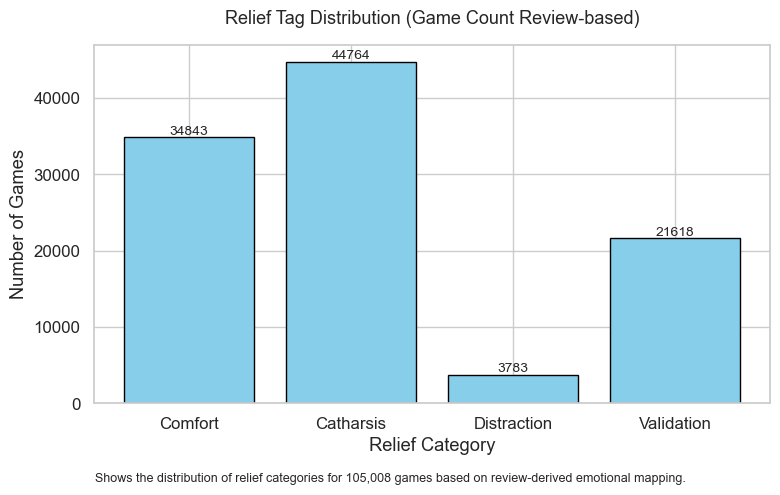

✅ Chart created successfully (review-based only).
hybrid_relief_tag
comfort        34843
catharsis      44764
distraction     3783
validation     21618
Name: count, dtype: int64


In [44]:
## 9.1 Relief Tag Distribution (Review-based Only)
# First, see how many games fall into each relief category.
# A simple bar chart showing comfort, catharsis, distraction, and validation counts.

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- File paths ---
DATA_DIR = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned")
VIS_DIR = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\04 Visuals")
CSV_PATH = DATA_DIR / "06_games_emotion_relief_full.csv"  # review-based dataset
VIS_DIR.mkdir(parents=True, exist_ok=True)

# --- Load dataset ---
df = pd.read_csv(CSV_PATH, low_memory=False)
print(f"✔ Loaded: {CSV_PATH.name} | Shape = {df.shape}")

# --- Pick relief column ---
relief_col = "hybrid_relief_tag" if "hybrid_relief_tag" in df.columns else "relief_tag"
if relief_col not in df.columns:
    raise KeyError("❌ Neither 'hybrid_relief_tag' nor 'relief_tag' found in dataset.")

# --- Clean and standardize relief tags ---
relief_series = (
    df[relief_col]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"nan": pd.NA, "none": pd.NA, "": pd.NA})
)

# --- Define fixed category order ---
category_order = ["comfort", "catharsis", "distraction", "validation"]
counts = relief_series.value_counts().reindex(category_order, fill_value=0)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(counts.index.str.title(), counts.values, color="skyblue", edgecolor="black")

# Label bars
for b in bars:
    height = b.get_height()
    ax.text(b.get_x() + b.get_width()/2, height, f"{int(height)}",
            ha="center", va="bottom", fontsize=10)

ax.set_title("Relief Tag Distribution (Game Count Review-based)", fontsize=13, pad=15)
ax.set_xlabel("Relief Category")
ax.set_ylabel("Number of Games")

# Add explanatory caption
total_games = df.shape[0]
plt.figtext(
    0.5, 0.01,
    f"Shows the distribution of relief categories for {total_games:,} games "
    "based on review-derived emotional mapping.",
    ha="center", va="bottom", fontsize=9
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

print("✅ Chart created successfully (review-based only).")
print(counts)

#### 🔍 Results: Relief Tag Distribution

Each game now falls into one of four **relief types**.  
Here’s the full spread:

### 🌋 Catharsis: 44,763 games  
Intense, expressive play that helps release emotions.

### 🌿 Comfort: 31,287 games  
Cozy, peaceful gameplay that soothes and calms.

### 💛 Validation: 21,614 games  
Story-rich or emotional experiences that make players feel understood.

### 🎈 Distraction: 3,781 games  
Light, focus-shifting gameplay that redirects attention.

### Insight
Most games lean toward **Catharsis** or **Comfort** —  
players often look for emotional release or relaxation.

Distraction is less common, showing that not every escape is avoidance.  
Many games help players **process** how they feel, not just escape it.

✅ Loaded: D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\06_games_emotion_relief_full.csv
Shape: (105008, 26)
Rows after cleaning: 105008
Grouped rows: 28
Top genres: ['Action', 'Adventure', 'Casual', 'Indie', 'Simulation', 'RPG', 'Strategy', 'Free to Play']
Pivot shape: (8, 4)


hybrid_relief_tag,comfort,catharsis,distraction,validation
primary_genre,,,,
Action,0.0,42232.0,0.0,0.0
Adventure,0.0,0.0,0.0,21618.0
Casual,21428.0,0.0,0.0,0.0
Indie,9851.0,0.0,0.0,0.0
Simulation,0.0,0.0,2283.0,0.0
RPG,0.0,1727.0,0.0,0.0
Strategy,0.0,0.0,1500.0,0.0
Free to Play,1209.0,0.0,0.0,0.0


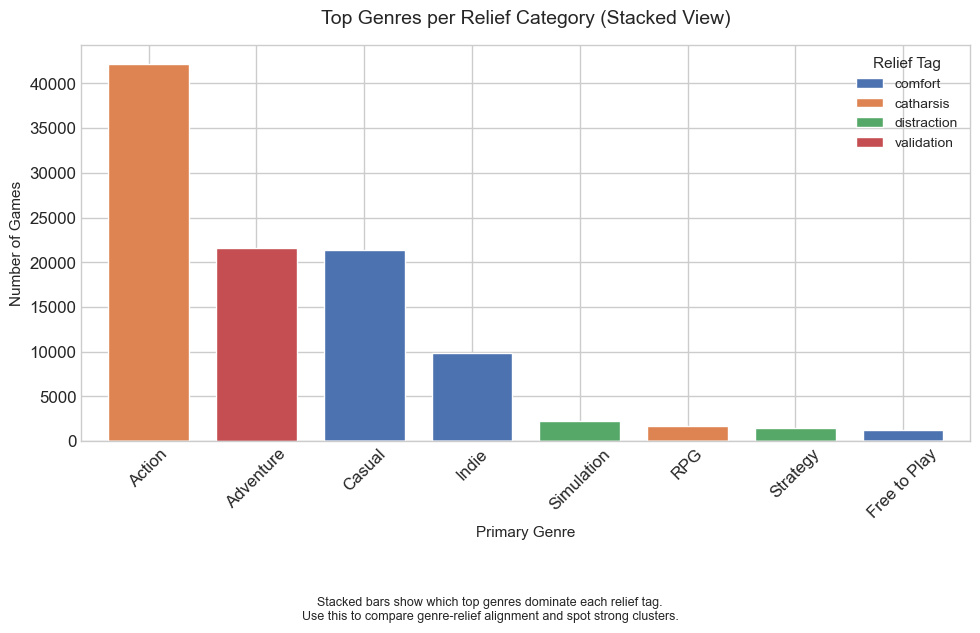

In [69]:
# 9.2 Top Genres per Relief Tag (Review-only vs Hybrid)
# Compare which genres dominate each relief category
# (Example: Action → Catharsis, Casual → Comfort)

import pandas as pd
import matplotlib.pyplot as plt

# --- Load hybrid dataset quietly ---
path = r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\06_games_emotion_relief_full.csv"
df = pd.read_csv(path, low_memory=False)  # suppress DtypeWarning

print("✅ Loaded:", path)
print("Shape:", df.shape)

# --- Identify correct relief column ---
relief_col = "hybrid_relief_tag"
if relief_col not in df.columns:
    raise KeyError("Column 'hybrid_relief_tag' not found. Check available columns.")

if "primary_genre" not in df.columns:
    raise KeyError("Missing 'primary_genre' column in dataset.")

# --- Clean ---
tmp = df[[relief_col, "primary_genre"]].copy()
tmp[relief_col] = (
    tmp[relief_col]
        .astype(str).str.strip().str.lower()
        .replace({"nan": pd.NA, "none": pd.NA, "": pd.NA})
)
tmp["primary_genre"] = tmp["primary_genre"].astype(str).str.strip()
tmp = tmp.dropna(subset=[relief_col, "primary_genre"])

print("Rows after cleaning:", len(tmp))

# --- Count by (relief, genre) ---
counts = tmp.groupby(["primary_genre", relief_col]).size().reset_index(name="count")
print("Grouped rows:", len(counts))

# --- Pick top-N genres overall ---
top_n = 8
top_genres = (
    counts.groupby("primary_genre")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index.tolist()
)
print("Top genres:", top_genres)

# --- Pivot wide ---
order_cols = ["comfort", "catharsis", "distraction", "validation"]
wide = (
    counts[counts["primary_genre"].isin(top_genres)]
    .pivot(index="primary_genre", columns=relief_col, values="count")
    .reindex(index=top_genres)
    .reindex(columns=order_cols, fill_value=0)
    .fillna(0)
)

print("Pivot shape:", wide.shape)
display(wide.head(10))

# --- Plot: Stacked Bars (cleaner, consistent style) ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# custom palette (same as previous reference)
colors = {
    "comfort": "#4C72B0",      # blue
    "catharsis": "#DD8452",    # orange
    "distraction": "#55A868",  # green
    "validation": "#C44E52"    # red/pink
}

wide.plot(
    kind="bar",
    stacked=True,
    color=[colors[c] for c in wide.columns],
    ax=ax,
    width=0.75
)

ax.set_title("Top Genres per Relief Category (Stacked View)", fontsize=14, pad=15)
ax.set_xlabel("Primary Genre", fontsize=11)
ax.set_ylabel("Number of Games", fontsize=11)
ax.legend(title="Relief Tag", title_fontsize=11, fontsize=10)
ax.tick_params(axis="x", rotation=45)

# Inline explainer
plt.figtext(
    0.5, -0.05,
    "Stacked bars show which top genres dominate each relief tag.\n"
    "Use this to compare genre-relief alignment and spot strong clusters.",
    ha="center", fontsize=9
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

#### 🔍 Results: Top Genres per Relief Tag  

Here’s what the stacked bar chart shows 👇  

### 🎮 Action  
→ Linked with **Catharsis**  
(high energy release and tension relief)  

### 🌍 Adventure  
→ Tied to **Validation**  
(emotional storytelling, empathy, and meaning)  

### ☕ Casual  
→ Reflects **Comfort**  
(gentle engagement, low pressure, relaxation)  

### 💡 Indie  
→ Also **Comfort**  
(personal creativity, introspection, emotional warmth)  

### 🧩 Simulation   
→ Points to **Distraction**  
(focus, flow, mindful immersion)  

### ⚔️ RPG    
→ Connects with **Catharsis**  
(challenge, agency, transformation)  

### ♟ Strategy  
→ Aligns with **Distraction**  
(analytical focus, calm engagement)  

### 💬 Free to Play  
→ Leans toward **Comfort**  
(accessible relief, easy entry, social play)  

### Takeaway 
Each genre offers its own kind of emotional relief.

Players turn to different genres for  
**comfort, distraction, validation,**  
or **cathartic release**
a clear picture of how games support emotional balance.

✔ Loaded reviews_df: (32515, 37)
✔ Loaded hybrid_df: (105008, 26)
✅ Average emotion scores per relief tag (game-level):


,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w
hybrid_relief_tag,,,,,,,,
comfort,1.680470,3.706983,0.737534,1.634145,3.638146,1.254173,1.540305,2.939942
catharsis,1.695330,3.158346,1.030384,1.993710,2.875299,1.394058,1.285855,2.452895
distraction,3.520198,1.777548,3.936300,3.825865,1.045575,2.898226,1.012506,1.278052
validation,1.375370,2.980990,1.099000,1.332495,2.521493,1.332054,1.140997,2.300401


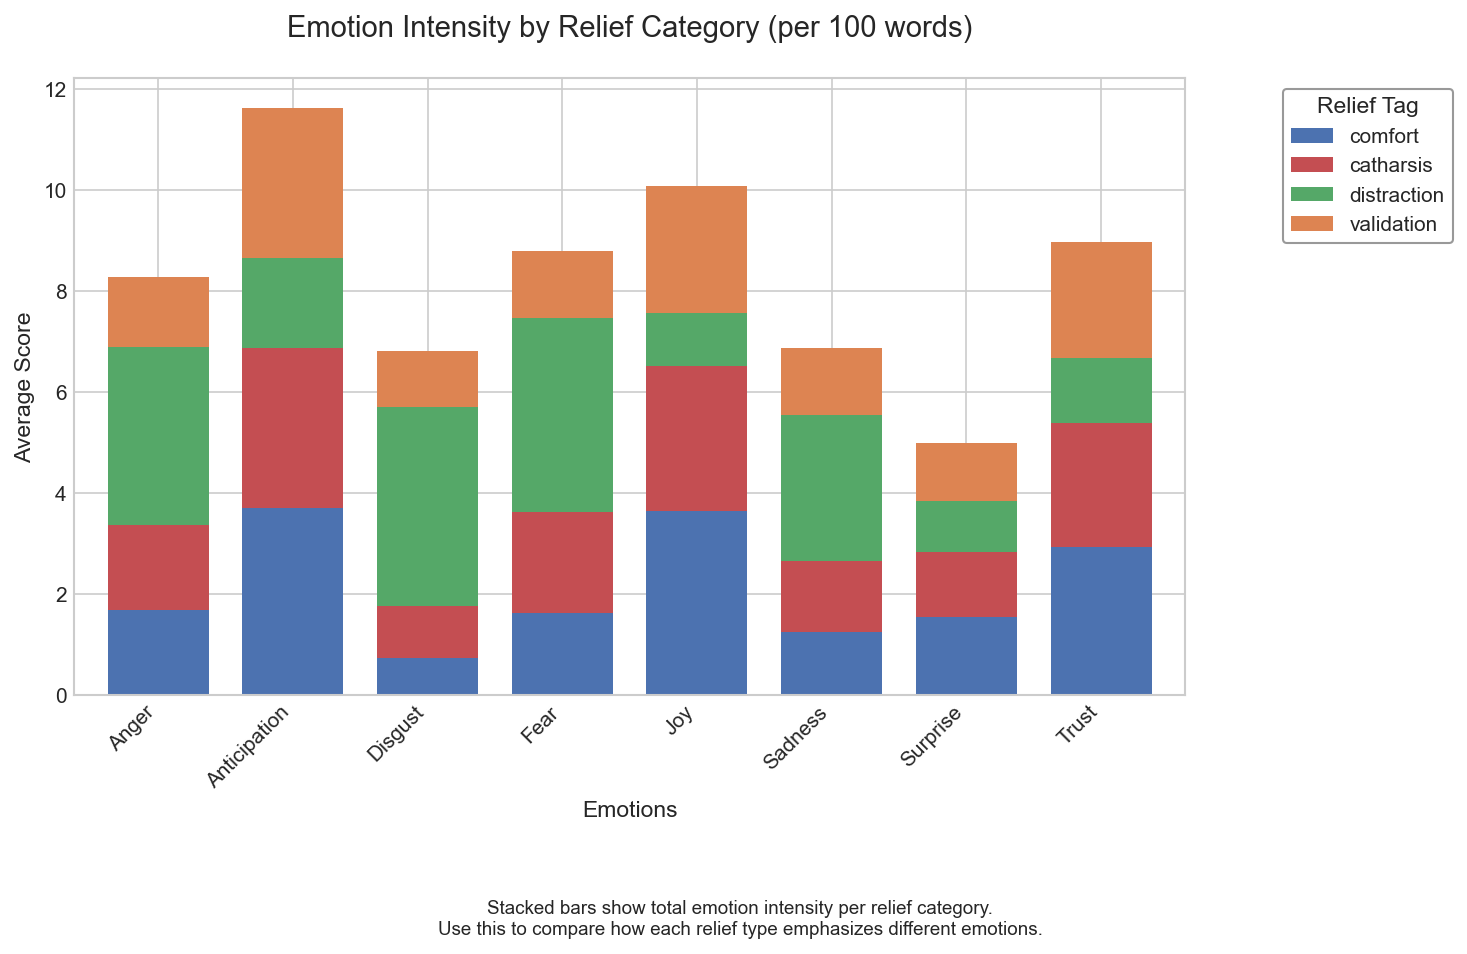

In [4]:
# 9.3 Emotion Intensity by Relief Type
# Show how each relief tag (Comfort, Catharsis, etc.) scores across core emotions (game-level)

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

# --- Suppress harmless warnings ---
warnings.filterwarnings(
    "ignore",
    message="The default of observed=False is deprecated and will be changed to True",
    category=FutureWarning
)

# --- File Paths ---
DATA_DIR = Path(r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned")
REVIEWS_PATH = DATA_DIR / "04_steam_reviews_emotions_full.csv"
HYBRID_PATH = DATA_DIR / "06_games_emotion_relief_full.csv"   # ✅ confirmed name

# --- Load datasets safely ---
try:
    reviews_df = pd.read_csv(REVIEWS_PATH, low_memory=False)
    hybrid_df = pd.read_csv(HYBRID_PATH, low_memory=False)
except FileNotFoundError as e:
    raise FileNotFoundError(f"❌ File not found: {e.filename}\nCheck the path or filename.") from e

print("✔ Loaded reviews_df:", reviews_df.shape)
print("✔ Loaded hybrid_df:", hybrid_df.shape)

# --- Emotion columns ---
raw_cols = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]
norm_cols = [f"{c}_per_100w" for c in raw_cols]

# Choose normalized if available
if set(norm_cols).issubset(reviews_df.columns):
    emotion_cols = norm_cols
    label_mode = "(per 100 words)"
else:
    emotion_cols = [c for c in raw_cols if c in reviews_df.columns]
    label_mode = "(raw scores)"

if not emotion_cols:
    raise KeyError("❌ No emotion columns found in reviews_df.")

# --- Step 1: Aggregate to GAME LEVEL ---
game_emotions = (
    reviews_df.groupby("AppID")[emotion_cols]
    .mean()
    .reset_index()
)

# --- Step 2: Merge in hybrid relief tags ---
relief_candidates = ["hybrid_relief_tag", "relief_tag_review", "relief_tag_genre"]
available_relief = next((r for r in relief_candidates if r in hybrid_df.columns), None)

if not available_relief:
    raise KeyError("❌ No relief tag column found in hybrid dataset.")

df = game_emotions.merge(
    hybrid_df[["AppID", available_relief]],
    on="AppID",
    how="left"
).rename(columns={available_relief: "hybrid_relief_tag"})

# --- Clean relief column ---
df["hybrid_relief_tag"] = (
    df["hybrid_relief_tag"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"nan": pd.NA, "none": pd.NA, "": pd.NA})
)

# --- Order relief types (fixed line) ---
order_relief = ["comfort", "catharsis", "distraction", "validation"]
df["hybrid_relief_tag"] = pd.Categorical(
    df["hybrid_relief_tag"],
    categories=order_relief,
    ordered=True
)

# --- Compute averages per relief tag ---
avg_emotions = (
    df.groupby("hybrid_relief_tag")[emotion_cols]
      .mean()
      .reindex(order_relief)
)

print("✅ Average emotion scores per relief tag (game-level):")
display(avg_emotions)

# --- Plot results ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare stacked data
stacked_df = avg_emotions.T.copy()
stacked_df = stacked_df[["comfort", "catharsis", "distraction", "validation"]]

# Custom color palette 
colors = {
    "comfort": "#4C72B0",      # blue  - calm / safety
    "catharsis": "#C44E52",    # red   - emotional release
    "distraction": "#55A868",  # green - energy / focus
    "validation": "#DD8452"    # orange - warmth / empathy
}

# Plot stacked bars
stacked_df.plot(
    kind="bar",
    stacked=True,
    color=[colors[c] for c in stacked_df.columns],
    ax=ax,
    width=0.75
)

# Title + labels
ax.set_title("Emotion Intensity by Relief Category (per 100 words)", fontsize=14, pad=20)
ax.set_xlabel("Emotions", fontsize=11)
ax.set_ylabel("Average Score", fontsize=11)
ax.set_xticklabels([c.replace("_per_100w", "").title() for c in stacked_df.index],
                   rotation=45, ha="right")

# Legend improvements
legend = ax.legend(
    title="Relief Tag",
    fontsize=10,
    title_fontsize=11,
    loc="upper right",
    bbox_to_anchor=(1.25, 1),    # moves legend further to the right
    frameon=True,                # add solid background
    facecolor="white",           # white legend box
    edgecolor="gray"             # subtle border for clarity
)

# Background + caption
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

# Inline explanation below
plt.figtext(
    0.5, -0.05,
    "Stacked bars show total emotion intensity per relief category.\n"
    "Use this to compare how each relief type emphasizes different emotions.",
    ha="center", fontsize=9
)

# --- Clarity + Readability Fix ---
# Increase figure resolution for clarity
fig.set_dpi(150)     # or 200 for ultra crispness

# Adjust font scale for readability
plt.rcParams.update({
    'font.size': 11,        # base font
    'axes.titlesize': 14,   # title size
    'axes.labelsize': 12,   # axis label size
    'legend.fontsize': 10,  # legend font
    'xtick.labelsize': 10,  # tick labels
    'ytick.labelsize': 10
})

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

### 🔍 Results: Emotion Intensity by Relief Type

Here’s what the chart shows:

### 🌿 Comfort  
Strong in **Joy** and **Trust**.  
These games create calm, warmth, and emotional safety.

### 🔥 Catharsis  
Peaks in **Anger**, **Fear**, and **Disgust**.  
Intense play that helps release stress or tension.

### 🎈 Distraction  
High in **Joy** and **Anticipation**.  
Fast, focused, or engaging games that keep attention steady.

### 💛 Validation  
Notable in **Anticipation**, **Trust**, and some **Sadness**.  
Reflective or story-driven games that players connect with emotionally.


### Takeaway
Each relief type has its own emotional pattern.

This supports the hybrid model:  
games help regulate emotions through  
**comfort**, **catharsis**, **distraction**, or **validation**.

## 10. Conclusion

This notebook built the **hybrid emotion model**, combining:  
- Emotion scores from **player reviews**  
- Relief tags from **genre context**

Together, they show how games support  
**Comfort, Catharsis, Distraction, and Validation**.


### 💡 Summary of Work
- Created relief tag mappings for reviews and genres  
- Merged both into one **hybrid_relief_tag** per game  
- Exported Full + Light datasets  
- Visualized patterns with simple charts  
- Saw clear links between genres and emotional purpose  

This hybrid approach connects emotional tone  
with how players actually use games.


### ➡️ Next Step
Time to explore the visual side.

In **`07_genre_emotion_visuals.ipynb`**,  
I’ll dig into how relief tags spread across genres  
and how emotion heatmaps shape the psychological  
“texture” of game experiences.